In [5]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [6]:
# Monthly Air Passengers from January 1949 to December 1960
df = pd.read_csv('../data/air-passengers.csv')
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


#### 8.3.2 Forecasting with a SARIMA(p,d,q)(P,D,Q)_m model

In [7]:
# Pg 172

ad_fuller_result = adfuller(df['Passengers'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 0.8153688792060441
p-value: 0.9918802434376409


In [8]:
df['Passengers'].tail() #$hape (144,)

139    606
140    508
141    461
142    390
143    432
Name: Passengers, dtype: int64

In [9]:
# Pg 172

# df_diff = np.diff(df['Passengers'], n=12) # n=12 differences lag 1 12 consecutive times, instead:
# Panda Series
# df_diff = df['Passengers'][12:].reset_index(drop=True) - df['Passengers'][:-12] #type:pandas.core.series.Series 
# this differences once lag 12, which is what we want, or
# Numpy Array
df_diff = df['Passengers'][12:].values - df['Passengers'][:-12].values # type:numpy.ndarray # this also differences once lag 12, which is what we want

ad_fuller_result = adfuller(df_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -3.3830207264924805
p-value: 0.011551493085514982


## d=0, D=1

In [6]:
df_diff

array([ 3,  8,  9,  6,  4, 14, 22, 22, 22, 14, 10, 22, 30, 24, 37, 28, 47,
       29, 29, 29, 26, 29, 32, 26, 26, 30, 15, 18, 11, 40, 31, 43, 25, 29,
       26, 28, 25, 16, 43, 54, 46, 25, 34, 30, 28, 20,  8,  7,  8, -8, -1,
       -8,  5, 21, 38, 21, 22, 18, 23, 28, 38, 45, 32, 42, 36, 51, 62, 54,
       53, 45, 34, 49, 42, 44, 50, 44, 48, 59, 49, 58, 43, 32, 34, 28, 31,
       24, 39, 35, 37, 48, 52, 62, 49, 41, 34, 30, 25, 17,  6,  0,  8, 13,
       26, 38,  0, 12,  5,  1, 20, 24, 44, 48, 57, 37, 57, 54, 59, 48, 52,
       68, 57, 49, 13, 65, 52, 63, 74, 47, 45, 54, 28, 27])

It is stationary after the first seasonal differencing.  We do d=0 and D=1 

In [7]:
def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(
                endog, 
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [ ]:
# Pg 174

ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)

SARIMA_order_list = list(product(ps, qs, Ps, Qs))

train = df['Passengers'][:-12] # len 132
#test = df['Passengers'][-12:]  # len 12

d = 0
D = 1
s = 12

# SARIMA_result_df = optimize_SARIMA(train, SARIMA_order_list, d, D, s)
# SARIMA_result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(3, 1, 3, 2)",20.000000
1,"(2, 0, 1, 2)",903.463992
2,"(2, 0, 2, 1)",904.383362
3,"(1, 1, 1, 2)",904.481178
4,"(2, 0, 2, 2)",905.137420
...,...,...
248,"(0, 0, 1, 0)",1110.241607
249,"(0, 0, 0, 3)",1128.638123
250,"(0, 0, 0, 2)",1128.851859
251,"(0, 0, 0, 1)",1157.168128


SARIMA_result_df = optimize_SARIMA(train, SARIMA_order_list, d, D, s)  
	(p,q,P,Q)	AIC  
0	(3, 1, 3, 2)	20.000000  
1	(2, 0, 1, 2)	903.463992  
2	(2, 0, 2, 1)	904.383362  
3	(1, 1, 1, 2)	904.481178  
4	(2, 0, 2, 2)	905.137420  

***************************************************************************
Pick a Model and analyze residuals

We pick SARIMA(3,0,1)(3,1,2)_12, which has the lowest AIC

In [9]:
SARIMA_model = SARIMAX(train, order=(3,0,1), seasonal_order=(3,1,2,12), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False, method='nm') # method='powell'

print(SARIMA_model_fit.summary())

                                        SARIMAX Results                                        
Dep. Variable:                              Passengers   No. Observations:                  132
Model:             SARIMAX(3, 0, 1)x(3, 1, [1, 2], 12)   Log Likelihood                -454.757
Date:                                 Tue, 10 Feb 2026   AIC                            929.515
Time:                                         14:29:52   BIC                            957.390
Sample:                                              0   HQIC                           940.835
                                                 - 132                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3349      0.774      0.433      0.665      -1.182       1

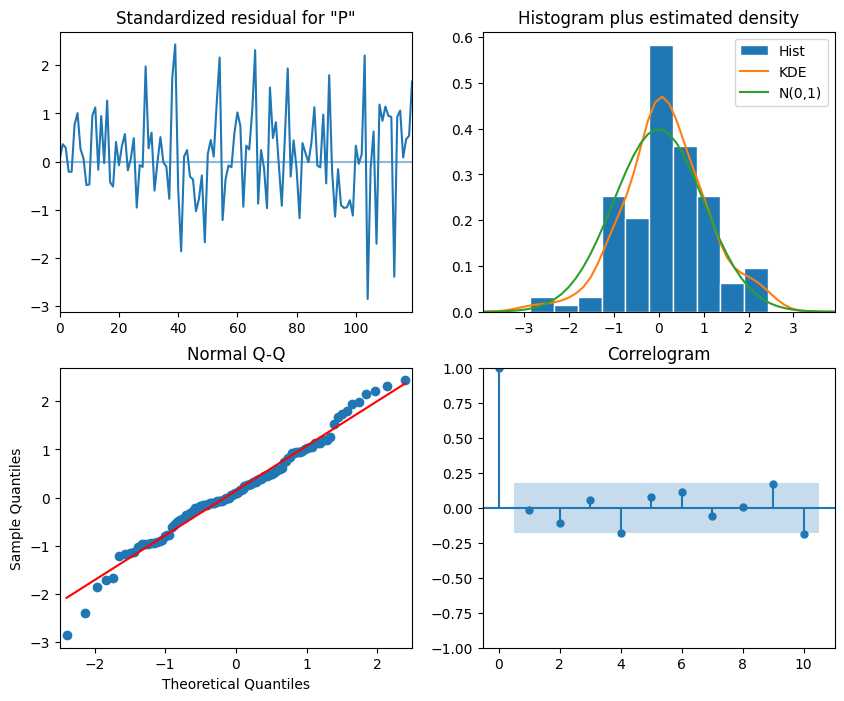

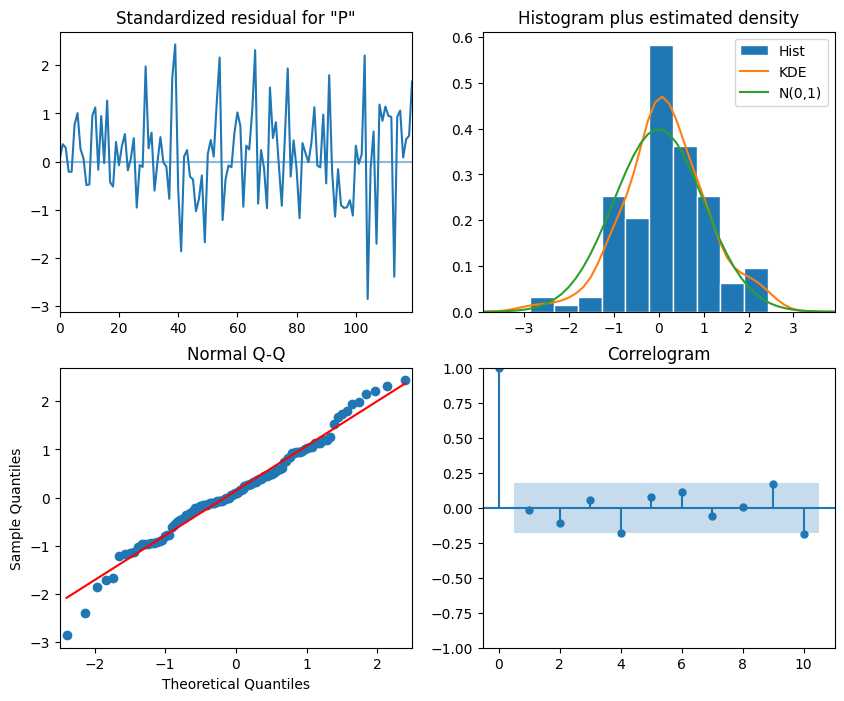

In [10]:
SARIMA_model_fit.plot_diagnostics(figsize=(10,8))

In [11]:
residuals = SARIMA_model_fit.resid

lb_dataframe = acorr_ljungbox(residuals, np.arange(1, 11, 1))

lb_dataframe

,lb_stat,lb_pvalue
1,100.979434,9.294346e-24
2,187.354286,2.072687e-41
3,260.366533,3.745561e-56
4,314.883736,6.664006e-67
5,358.004771,3.307790e-75
6,388.703059,7.495802e-81
7,407.423733,6.100443e-84
8,418.864928,1.721286e-85
9,425.405099,5.166398e-86
10,427.235258,1.491248e-85


SARIMA(3,0,1)(3,1,2)_12, Ljung-Box test we can reject null hypothesis for lags 1 to lag 20  

Let's try one more. We pick now SARIMA(2,0,0)(1,1,2)_12 

In [12]:
SARIMA_model = SARIMAX(train, order=(2,0,0), seasonal_order=(1,1,2,12), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False, method='nm') # method='powell'
print(SARIMA_model_fit.summary())

                                        SARIMAX Results                                        
Dep. Variable:                              Passengers   No. Observations:                  132
Model:             SARIMAX(2, 0, 0)x(1, 1, [1, 2], 12)   Log Likelihood                -447.230
Date:                                 Tue, 10 Feb 2026   AIC                            906.460
Time:                                         14:31:50   BIC                            923.184
Sample:                                              0   HQIC                           913.252
                                                 - 132                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6332      0.082      7.754      0.000       0.473       0

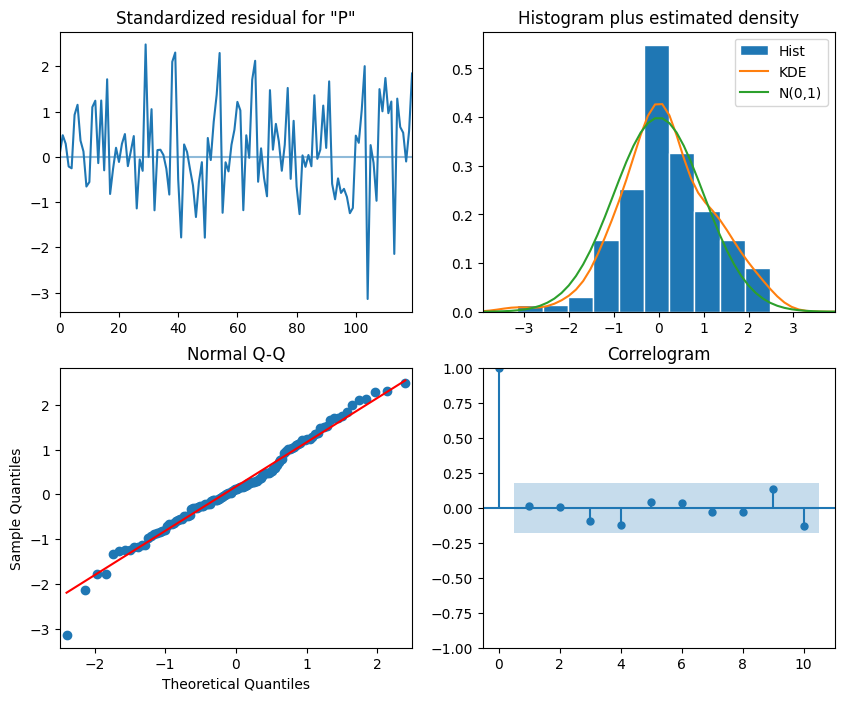

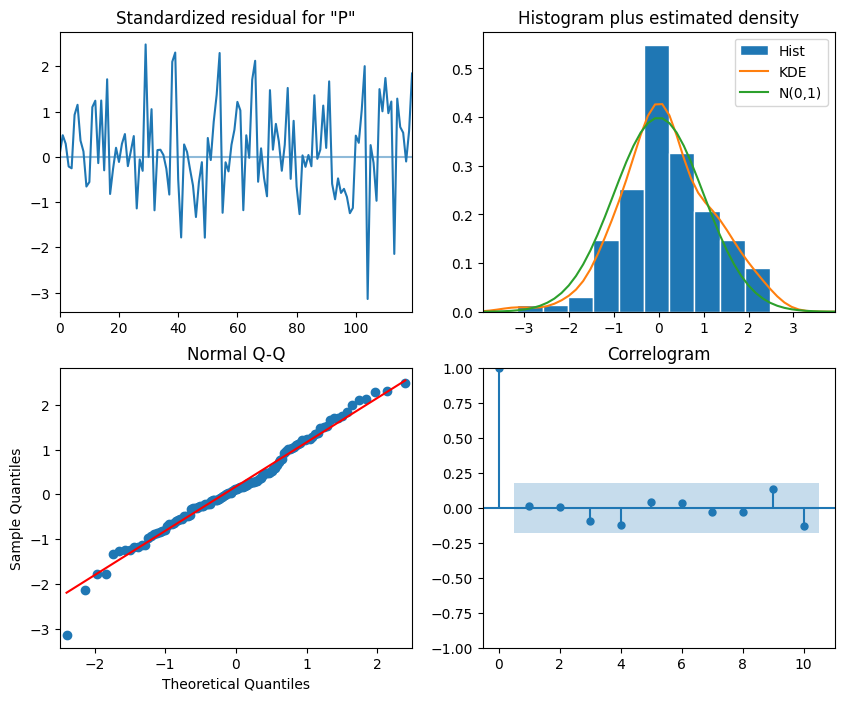

In [13]:
SARIMA_model_fit.plot_diagnostics(figsize=(10,8))

In [14]:
residuals = SARIMA_model_fit.resid
lb_dataframe = acorr_ljungbox(residuals, np.arange(1, 11, 1))
lb_dataframe

,lb_stat,lb_pvalue
1,102.569259,4.165472e-24
2,191.646869,2.423323e-42
3,263.556625,7.645776e-57
4,319.376923,7.147711e-68
5,362.373040,3.791728e-76
6,392.635944,1.070292e-81
7,411.668784,7.494785e-85
8,422.993282,2.249623e-86
9,429.345619,7.438135e-87
10,431.279619,2.049360e-86


SARIMA(2,0,0)(1,1,2)_12 , Ljung-Box test we can reject null hypothesis for lags 1 to lag 20  

Let's pick the first one, SARIMA(3,0,1)(3,1,2)_12

*******************************************************************************************
Forecast with model

In [15]:
SARIMA_model = SARIMAX(train, order=(3,0,1), seasonal_order=(3,1,2,12), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False, method='nm') # method='powell'
#print(SARIMA_model_fit.summary())

In [16]:
test = df.iloc[-12:]

test['naive_seasonal'] = df['Passengers'].iloc[120:132].values
test

,Month,Passengers,naive_seasonal
132,1960-01,417,360
133,1960-02,391,342
134,1960-03,419,406
135,1960-04,461,396
136,1960-05,472,420
137,1960-06,535,472
138,1960-07,622,548
139,1960-08,606,559
140,1960-09,508,463
141,1960-10,461,407


In [17]:
# Pg 175

SARIMA_pred = SARIMA_model_fit.get_prediction(132, 143).predicted_mean

test['SARIMA_pred'] = SARIMA_pred
test

,Month,Passengers,naive_seasonal,SARIMA_pred
132,1960-01,417,360,415.486394
133,1960-02,391,342,395.103144
134,1960-03,419,406,455.475494
135,1960-04,461,396,440.960108
136,1960-05,472,420,462.911371
137,1960-06,535,472,529.547184
138,1960-07,622,548,601.021577
139,1960-08,606,559,620.008222
140,1960-09,508,463,505.362607
141,1960-10,461,407,445.859429


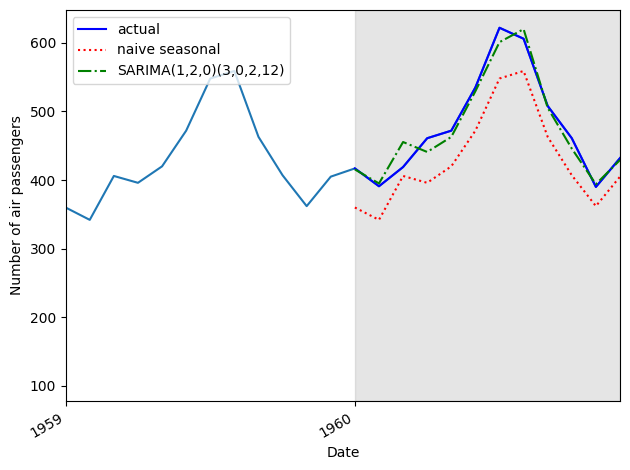

In [18]:
# Figure 8.13 in pg 176

fig, ax = plt.subplots()

ax.plot(df['Month'], df['Passengers'])
ax.plot(test['Passengers'], 'b-', label='actual')
ax.plot(test['naive_seasonal'], 'r:', label='naive seasonal')
#ax.plot(test['ARIMA_pred'], 'k--', label='ARIMA(11,2,3)')
ax.plot(test['SARIMA_pred'], 'g-.', label='SARIMA(1,2,0)(3,0,2,12)')

ax.set_xlabel('Date')
ax.set_ylabel('Number of air passengers')
ax.axvspan(132, 143, color='#808080', alpha=0.2)

ax.legend(loc=2)

plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))
ax.set_xlim(120, 143)

fig.autofmt_xdate()
plt.tight_layout()


In [19]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [20]:
mape_naive_seasonal = mape(test['Passengers'], test['naive_seasonal'])
#mape_ARIMA = mape(test['Passengers'], test['ARIMA_pred'])
mape_SARIMA = mape(test['Passengers'], test['SARIMA_pred'])

print(mape_naive_seasonal, mape_SARIMA)

9.987532920823485 2.3805693595659054


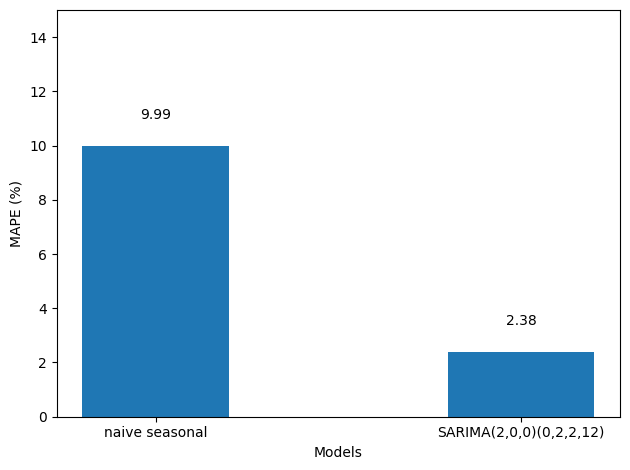

In [21]:
# Figure 8.14 in pg 177

fig, ax = plt.subplots()

x = ['naive seasonal', 'SARIMA(2,0,0)(0,2,2,12)']
y = [mape_naive_seasonal, mape_SARIMA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 15)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')

plt.tight_layout()

plt.savefig('figures/CH08_F14_peixeiro.png', dpi=300)

d=0. D=1, SARIMA(3,0,1)(3,1,2)_12: 2.38% off

d=0. D=2, SARIMA(2,0,0)(0,2,2)_12: 2.29% off

d=1, D=1, SARIMA(2,1,1)(1,1,2)_12: 2.85% off

For simplicity, looks like the first one is the way to go
